### Spark Session


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Iceberg with PostgreSQL") \
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.9.1,org.postgresql:postgresql:42.7.3") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog") \
    .config("spark.sql.catalog.spark_catalog.type", "hadoop") \
    .config("spark.sql.catalog.spark_catalog.warehouse", "file:///C:/Users/MSI/OneDrive/Desktop/warehouse") \
    .config("spark.sql.catalog.local", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.local.type", "hadoop") \
    .config("spark.sql.catalog.local.warehouse", "file:///C:/Users/MSI/OneDrive/Desktop/warehouse") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

spark

### Read Dataset

In [2]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5433/ingest_db") \
    .option("dbtable", 'public."green_tripdata_summary_all"') \
    .option("user", "ingest_user") \
    .option("password", "ingest_password") \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [3]:
df.count()

145455

In [4]:
df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+------------------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+-------------------+-------------------+------------------+------------------+---------------------+--------------------+
|            trip_uid|        vendor_label|          trip_month|        trip_quarter|            trip_day|        trip_weekday|day_type|           trip_hour|payment_type_label|trip_type|trip_count|        avg_distance|      total_distance|            avg_fare|          total_fare|           total_tip|             avg_tip|           avg_total| avg_passenger_count|unique_pickup_locations|         first_trip|          last_trip|peak_morning_hours|peak_evening_hours|trip_duration_minutes|

### EDA

In [5]:
from pyspark.sql.functions import col, when

# Map numbers to month names using a series of when-otherwise
df_monthly_named = df.withColumn("trip_month", col("trip_month").cast("int")) \
    .withColumn("month_name", 
        when(col("trip_month") == 1, "January")
        .when(col("trip_month") == 2, "February")
        .when(col("trip_month") == 3, "March")
        .when(col("trip_month") == 4, "April")
        .when(col("trip_month") == 5, "May")
        .when(col("trip_month") == 6, "June")
        .when(col("trip_month") == 7, "July")
        .when(col("trip_month") == 8, "August")
        .when(col("trip_month") == 9, "September")
        .when(col("trip_month") == 10, "October")
        .when(col("trip_month") == 11, "November")
        .when(col("trip_month") == 12, "December")
    ) \
    .groupBy("month_name", "trip_month") \
    .sum("trip_count") \
    .withColumnRenamed("sum(trip_count)", "total_trip_count") \
    .orderBy("trip_month")  # ensures correct month order

df_monthly_named.show(12)


+----------+----------+----------------+
|month_name|trip_month|total_trip_count|
+----------+----------+----------------+
|   January|         1|         1012757|
|  February|         2|          948777|
|     March|         3|          853770|
|     April|         4|          624955|
|       May|         5|          624637|
|      June|         6|          599955|
|      July|         7|          553957|
|    August|         8|          523607|
| September|         9|          529510|
|   October|        10|          544463|
|  November|        11|          512033|
|  December|        12|          515666|
+----------+----------+----------------+



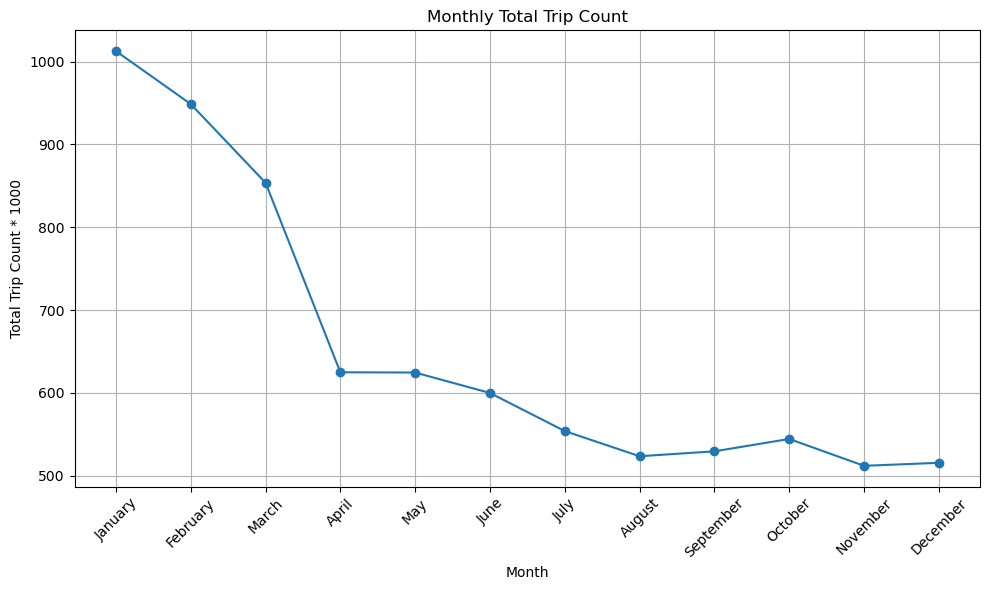

In [6]:
pdf = df_monthly_named.select("month_name", "total_trip_count").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pdf["month_name"], pdf["total_trip_count"]/1000, marker='o')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Trip Count * 1000")
plt.title("Monthly Total Trip Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

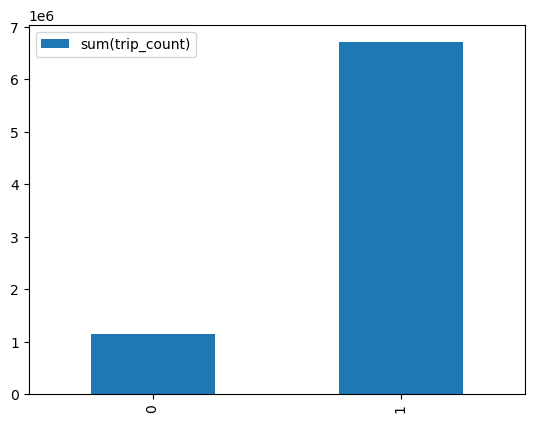

In [13]:
venodr_label = df.groupBy("vendor_label") \
    .sum("trip_count")

venodr_label.toPandas().plot(kind = 'bar')

### Write to Iceberg table

In [3]:
spark.sql("CREATE NAMESPACE IF NOT EXISTS local.taxi")

DataFrame[]

In [41]:
from pyspark.sql.functions import date_format, col
from pyspark.sql import SparkSession

# 1. Drop existing Iceberg table
spark.sql("DROP TABLE IF EXISTS local.taxi.green_tripdata_summary_iceberg")

DataFrame[]

In [43]:
# 2. Format trip_month as numeric string like "202401"
df = df.withColumn("trip_month", date_format("first_trip", "yyyy-MM"))

# 3. Cast it to decimal(38,18)
# df_casted = df.withColumn("trip_month", col("trip_month").cast("decimal(38,18)"))
# df_casted.show()

# 4. Write to Iceberg table, partitioned by trip_month
df.writeTo("local.taxi.green_tripdata_summary_iceberg") \
    .partitionedBy("trip_month") \
    .using("iceberg") \
    .createOrReplace()  # Or use `.overwrite()` depending on behavior you want

In [ ]:
# List all namespaces (databases) in the catalog
spark.sql("SHOW NAMESPACES IN local").show()


+---------+
|namespace|
+---------+
|     taxi|
+---------+



In [9]:
spark.sql("""
    SELECT * FROM local.taxi.green_tripdata_summary_iceberg.manifests
""").show(truncate=False)


+-------+---------------------------------------------------------------------------------------------------------------------------------------+------+-----------------+-------------------+----------------------+-------------------------+------------------------+------------------------+---------------------------+--------------------------+-------------------------------------------------------------+
|content|path                                                                                                                                   |length|partition_spec_id|added_snapshot_id  |added_data_files_count|existing_data_files_count|deleted_data_files_count|added_delete_files_count|existing_delete_files_count|deleted_delete_files_count|partition_summaries                                          |
+-------+---------------------------------------------------------------------------------------------------------------------------------------+------+-----------------+----------------

In [10]:
spark.sql("""
    SELECT * FROM local.taxi.green_tripdata_summary_iceberg.files
""").show(truncate=False)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-------+-----------------------+------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------

In [11]:
spark.sql("""
    SELECT * FROM local.taxi.green_tripdata_summary_iceberg.partitions
""").show(truncate=False)

+-----------------------+-------+------------+----------+-----------------------------+----------------------------+--------------------------+----------------------------+--------------------------+-----------------------+------------------------+
|partition              |spec_id|record_count|file_count|total_data_file_size_in_bytes|position_delete_record_count|position_delete_file_count|equality_delete_record_count|equality_delete_file_count|last_updated_at        |last_updated_snapshot_id|
+-----------------------+-------+------------+----------+-----------------------------+----------------------------+--------------------------+----------------------------+--------------------------+-----------------------+------------------------+
|{7.000000000000000000} |0      |12137       |1         |750944                       |0                           |0                         |0                           |0                         |2025-07-14 23:31:56.953|6517999124405759588     |
|{1.

In [12]:
spark.sql("""
    SELECT * FROM local.taxi.green_tripdata_summary_iceberg.entries
""").show(truncate=False)

+------+-------------------+---------------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
spark.stop()

In [65]:
import pandas as pd

# Spark session `spark` is already created in previous cells
spark = SparkSession.builder \
    .appName("Iceberg to Pandas") \
    .getOrCreate()
# Step 1: Read Iceberg table from the local catalog
# (spark_df is already defined, so we can use it directly)
# If you want to re-read, uncomment the next line:
spark_df = spark.read.table("local.taxi.green_tripdata_summary_iceberg")

# Optional: Apply filter and select columns
filtered_df = spark_df.filter("CAST(trip_month AS STRING) > '2021-01'") \
                      .sort("first_trip")

# Step 2: Convert to Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Display the result
pandas_df.head()


,trip_uid,vendor_label,trip_month,trip_quarter,trip_day,trip_weekday,day_type,trip_hour,payment_type_label,trip_type,...,avg_tip,avg_total,avg_passenger_count,unique_pickup_locations,first_trip,last_trip,peak_morning_hours,peak_evening_hours,trip_duration_minutes,tip_rate
0,9327a1f50a0eeaa0664cf3b3f7f0425b,VeriFone Inc.,2021-02,1.000000000000000000,1.000000000000000000,1.000000000000000000,Weekday,0E-18,Cash,Medium,...,0E-18,16.880000000000000000,1.000000000000000000,1,2021-02-01 00:04:00,2021-02-01 00:53:27,0,0,18.230000000000000000,0E-18
1,fda9bfb17c02682e72409f5ce1eb095a,VeriFone Inc.,2021-02,1.000000000000000000,1.000000000000000000,1.000000000000000000,Weekday,0E-18,Credit Card,Medium,...,3.960000000000000000,16.360000000000000000,1.800000000000000000,4,2021-02-01 00:06:50,2021-02-01 00:57:46,0,0,17.920000000000000000,0.350000000000000000
2,5d393272dbc7acf9d984d4be50d53af0,VeriFone Inc.,2021-02,1.000000000000000000,1.000000000000000000,1.000000000000000000,Weekday,1.000000000000000000,Cash,Short,...,0E-18,8.800000000000000000,1.000000000000000000,1,2021-02-01 01:25:20,2021-02-01 01:25:20,0,0,8.730000000000000000,0E-18
3,da99c9bd4f66eea38f744e878eb7c60a,VeriFone Inc.,2021-02,1.000000000000000000,1.000000000000000000,1.000000000000000000,Weekday,2.000000000000000000,Cash,Short,...,0E-18,11.430000000000000000,1.000000000000000000,2,2021-02-01 02:32:28,2021-02-01 02:53:46,0,0,11.800000000000000000,0E-18
4,ec763f6062de350a9dccf5c357bbeae3,VeriFone Inc.,2021-02,1.000000000000000000,1.000000000000000000,1.000000000000000000,Weekday,2.000000000000000000,Credit Card,Short,...,0E-18,10.800000000000000000,1.000000000000000000,1,2021-02-01 02:34:48,2021-02-01 02:34:48,0,0,9.770000000000000000,0E-18
